In [1]:
%matplotlib inline
%load_ext tensorboard

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil

try:
  shutil.rmtree('logs')
except:
  pass


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
def create_example(x,y):
    c=np.random.randint(0,2)
    image=0.5*np.random.rand(28,28,3)
    image[:,:,c] +=0.5*x/255
    return image, y,c

digit: 5, color: green


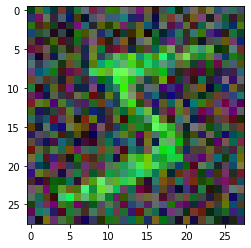

In [4]:
colors = {0: 'red', 1: 'green'}

x,y,c=create_example(x_train[0], y_train[0])
print(f'digit: {y}, color: {colors[c]}')

plt.imshow(x)
plt.show()

In [5]:
def generate_data(x,y,batch_size=32):
    num_examples=len(y)
    
    while True:
        x_batch=np.zeros((batch_size, 28,28,3))
        y_batch=np.zeros((batch_size,))
        c_batch=np.zeros((batch_size,))
        
        for i in range(0,batch_size):
            index=np.random.randint(0,num_examples)
            image, digit, color = create_example(x[index],y[index])
            x_batch[i] = image
            y_batch[i] = digit
            c_batch[i] = color
            
        yield x_batch, [y_batch, c_batch]
        
        

[7.] [0.]


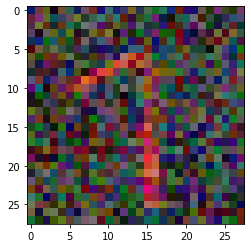

In [6]:
x,[y,c] = next(generate_data(x_test, y_test, batch_size=1))

print(y,c)
plt.imshow(x[0])

In [7]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Add, Dense
import graphviz

In [8]:
input_ = Input(shape=(28,28,3),name='input') # the input layer, where the images are input

conv_1= Conv2D(32,3, name= 'conv_1')(input_) #convolutional layer, taking the input layer as input
act_1 = Activation('relu', name='act_1')(conv_1) #relu activation function
#conv is Conv2D(filter size, kernal size, name)(input into this layer) kernal size is number of elements wide.
#padding is used to keep the same dimensions as the input image
#max pooling halves the size of the feature maps. It extracts features from the input feature map, outputs max values for each channel.
# an reduces the number of feature maps needed to process.
pool_1= MaxPool2D(4, name='pool_1')(act_1) #pooling and flattening layers
flat_1= Flatten(name= 'flat_1')(pool_1) #flattening converts input to a 1D array for next layer to use.
# creates a single, long feature vector.

color= Dense(1, activation = 'sigmoid', name= 'color')(flat_1) #first output


conv_2=Conv2D(32,3,padding='same', name='conv_2')(act_1)
#this is the second layer. This convolutional layer takes activation function 1 as input
act_2= Activation('relu', name='act_2')(conv_2)

conv_3=Conv2D(32,3, padding='same', name='conv_3')(act_2)
add = Add(name='add')([act_1, conv_3])  #this layer adds the output from conv_3 to output after act_1
act_3=Activation('relu', name='act_3')(add)

pool_2=MaxPool2D(4, name='pool_2')(act_3)
flat_2=Flatten(name='flat_2')(pool_2)

digit = Dense(10, activation='softmax', name='digit')(flat_2) #softmax gives us a prob dist

model=tf.keras.models.Model(input_, [digit,color])

#can have multiple loss functions for digit and color.
# will create dictionary
model.compile(
    loss={
        'digit': 'sparse_categorical_crossentropy',
        'color': 'binary_crossentropy'
    },
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 26, 26, 32)   896         input[0][0]                      
__________________________________________________________________________________________________
act_1 (Activation)              (None, 26, 26, 32)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 26, 26, 32)   9248        act_1[0][0]                      
______________________________________________________________________________________________

In [9]:
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
# creates a tree that shows how the layers and their inputs are connected.


In [10]:
class Logger(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    digit_accuracy = logs.get('digit_accuracy')
    color_accuracy = logs.get('color_accuracy')
    val_digit_accuracy = logs.get('val_digit_accuracy')
    val_color_accuracy = logs.get('val_color_accuracy')
    print('='*30, epoch + 1, '='*30)
    print(f'digit_accuracy: {digit_accuracy:.2f}, color_accuracy: {color_accuracy:.2f}')
    print(f'val_digit_accuracy: {val_digit_accuracy:.2f}, val_color_accuracy: {val_color_accuracy:.2f}')

In [11]:
train_gen= generate_data(x_train,y_train)
test_gen= generate_data(x_test,y_test)

_ = model.fit(
    train_gen,
    validation_data=test_gen,
    steps_per_epoch=200,
    validation_steps=100,
    epochs=10,
    callbacks=[Logger(), tf.keras.callbacks.TensorBoard(log_dir='logs')],
    verbose=False
)

============================== 1 ==============================
digit_accuracy: 0.58, color_accuracy: 0.97
val_digit_accuracy: 0.85, val_color_accuracy: 1.00
============================== 2 ==============================
digit_accuracy: 0.88, color_accuracy: 1.00
val_digit_accuracy: 0.91, val_color_accuracy: 1.00
============================== 3 ==============================
digit_accuracy: 0.92, color_accuracy: 1.00
val_digit_accuracy: 0.94, val_color_accuracy: 1.00
============================== 4 ==============================
digit_accuracy: 0.94, color_accuracy: 1.00
val_digit_accuracy: 0.96, val_color_accuracy: 1.00
============================== 5 ==============================
digit_accuracy: 0.96, color_accuracy: 1.00
val_digit_accuracy: 0.95, val_color_accuracy: 1.00
============================== 6 ==============================
digit_accuracy: 0.96, color_accuracy: 1.00
val_digit_accuracy: 0.97, val_color_accuracy: 1.00
============================== 7 ===================

In [12]:
%tensorboard --logdir logs #-use tensorboard, it's plotting is very good


Reusing TensorBoard on port 6006 (pid 17604), started 5:09:31 ago. (Use '!kill 17604' to kill it.)

In [13]:
def test_model(show=True):
  x, [y, c] = next(test)
  
  preds = model.predict(x)
  pred_digit = np.argmax(preds[0])
  pred_color = int(preds[1] > 0.5)
  gt_digit = int(y[0])
  gt_color = int(c[0])
  
  plt.imshow(x[0])
  if show:
    print(f'GT: {gt_digit}, {colors[gt_color]}')
    print(f'Pr: {pred_digit}, {colors[pred_color]}')
    plt.show()
  else:
    col = 'green' if gt_digit == pred_digit and gt_color == pred_color else 'red'
    plt.ylabel(f'GT: {gt_digit}, {colors[gt_color]}', color=col)
    plt.xlabel(f'Pr: {pred_digit}, {colors[pred_color]}', color=col)
    plt.xticks([])
    plt.yticks([])


test = generate_data(x_test, y_test, batch_size=1)

GT: 9, red
Pr: 9, red


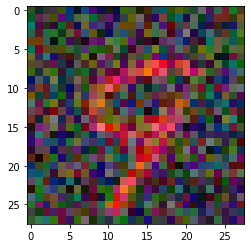

In [14]:
test_model()

ValueError: num must be 1 <= num <= 16, not 18

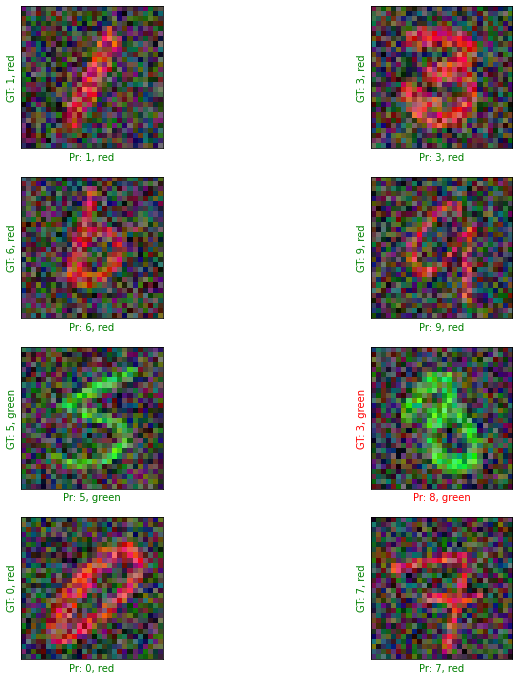

In [15]:
plt.figure(figsize=(12,12))
for i in range(1,16):
    plt.subplot(4,4,i+i)
    test_model(show=False)
plt.show()